# Fussing about with VLT/FORS2

In [24]:
%matplotlib notebook

In [111]:
# imports
import os
from matplotlib import pyplot as plt
from importlib import reload
from pkg_resources import resource_filename

import numpy as np

from astropy.io import fits
from astropy import units
from astropy.table import Table

from pypeit.core.wavecal import waveio, wvutils, fitting
from pypeit import wavecalib 
from pypeit.core import wave
from pypeit.spectrographs import vlt_fors
from pypeit import utils

## Load a frame

In [113]:
dfile = '/data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.357.fits'
spec_file = '/home/xavier/scratch/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits' #FORS2.2018-12-05T02:33:49.816.fits'
#arc_file = '/home/xavier/scratch/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T12:19:37.190.fits' # arc
std_file = '/home/xavier/scratch/FRB181112/data_with_raw_calibs/FORS2.2018-12-04T00:49:39.578.fits'

In [114]:
hdu = fits.open(std_file)

In [115]:
hdu[0].header

SIMPLE  =                    T          / Standard FITS format (NOST-100.0)     
BITPIX  =                   16          / # of bits storing pix values          
NAXIS   =                    2          / # of axes in frame                    
NAXIS1  =                 2048          / # pixels/axis                         
NAXIS2  =                 1034          / # pixels/axis                         
ORIGIN  = 'ESO     '                    / European Southern Observatory         
DATE    = '2018-12-04T00:50:37.555'     / UT date when this file was written    
MJD-OBS =       58456.03448586          / MJD start (2018-12-04T00:49:39.578)   
DATE-OBS= '2018-12-04T00:49:39.577'     / Date of observation                   
EXPTIME =              54.9913          / Total integration time                
CRVAL1  =             12.50575          / value of ref pixel                    
CRPIX1  =               1022.8          / Ref pixel in x-axis                   
CTYPE1  = 'RA---TAN'        

In [28]:
hdu.info()

Filename: /data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.357.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CHIP2         1 PrimaryHDU     290   (2048, 1034)   int16 (rescales to uint16)   


### Chip 1?

In [31]:
dfile2 = '/data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits'

In [33]:
hdu = fits.open(dfile2)
hdu.info()

Filename: /data/VLT/FORS2/FRB181112/data_with_raw_calibs/FORS2.2018-12-05T02:18:15.356.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  CHIP1         1 PrimaryHDU     275   (2048, 1034)   int16 (rescales to uint16)   


### Data image

In [74]:
reload(vlt_fors)
fors2 = vlt_fors.VLTFORS2Spectrograph()
par = fors2.default_pypeit_par()
par = fors2.config_specific_par(par, spec_file)

In [75]:
fors2.detector

[Parameter      Value     Default  Type              Callable
 ------------------------------------------------------------
 dataext        0         0        int               False   
 specaxis       1         0        int               False   
 specflip       False     False    bool              False   
 spatflip       False     False    bool              False   
 xgap           0.0       0.0      int, float        False   
 ygap           0.0       0.0      int, float        False   
 ysize          1.0       1.0      int, float        False   
 platescale     0.126     0.135    int, float        False   
 darkcurr       0.0       0.0      int, float        False   
 saturation     200000.0  65535.0  int, float        False   
 mincounts      -1000.0   -1000.0  int, float        False   
 nonlinear      0.8       0.86     int, float        False   
 numamplifiers  1         1        int               False   
 gain           0.7       4.0      int, float, list  False   
 ronoise

In [76]:
dsec = fors2.get_datasec_img(spec_file)

In [88]:
dsec[6,:].size

1034

----

## Wavelengths

In [89]:
wv_file = '/home/xavier/scratch/FRB181112/FORS2/vlt_fors2_E/MF_vlt_fors2/MasterWaveCalib_E_1_01.json'

In [90]:
wvcalib, par = wavecalib.load_wv_calib(wv_file)

[INFO]    :: wavecalib.py 331 load_master() - Loading Master wv_calib frame:
             /home/xavier/scratch/FRB181112/FORS2/vlt_fors2_E/MF_vlt_fors2/MasterWaveCalib_E_1_01.json


In [91]:
wvcalib['0'].keys()

dict_keys(['cen_disp', 'cen_wave', 'fitc', 'fmax', 'fmin', 'function', 'ions', 'mask', 'nrej', 'nspec', 'pixel_fit', 'rms', 'shift', 'spec', 'tcent', 'wave_fit', 'wave_soln', 'weights', 'xnorm', 'xrej', 'yrej'])

### ID a few by hand

In [92]:
spec = wvcalib['0']['spec']
spec.size

2048

<IPython.core.display.Javascript object>


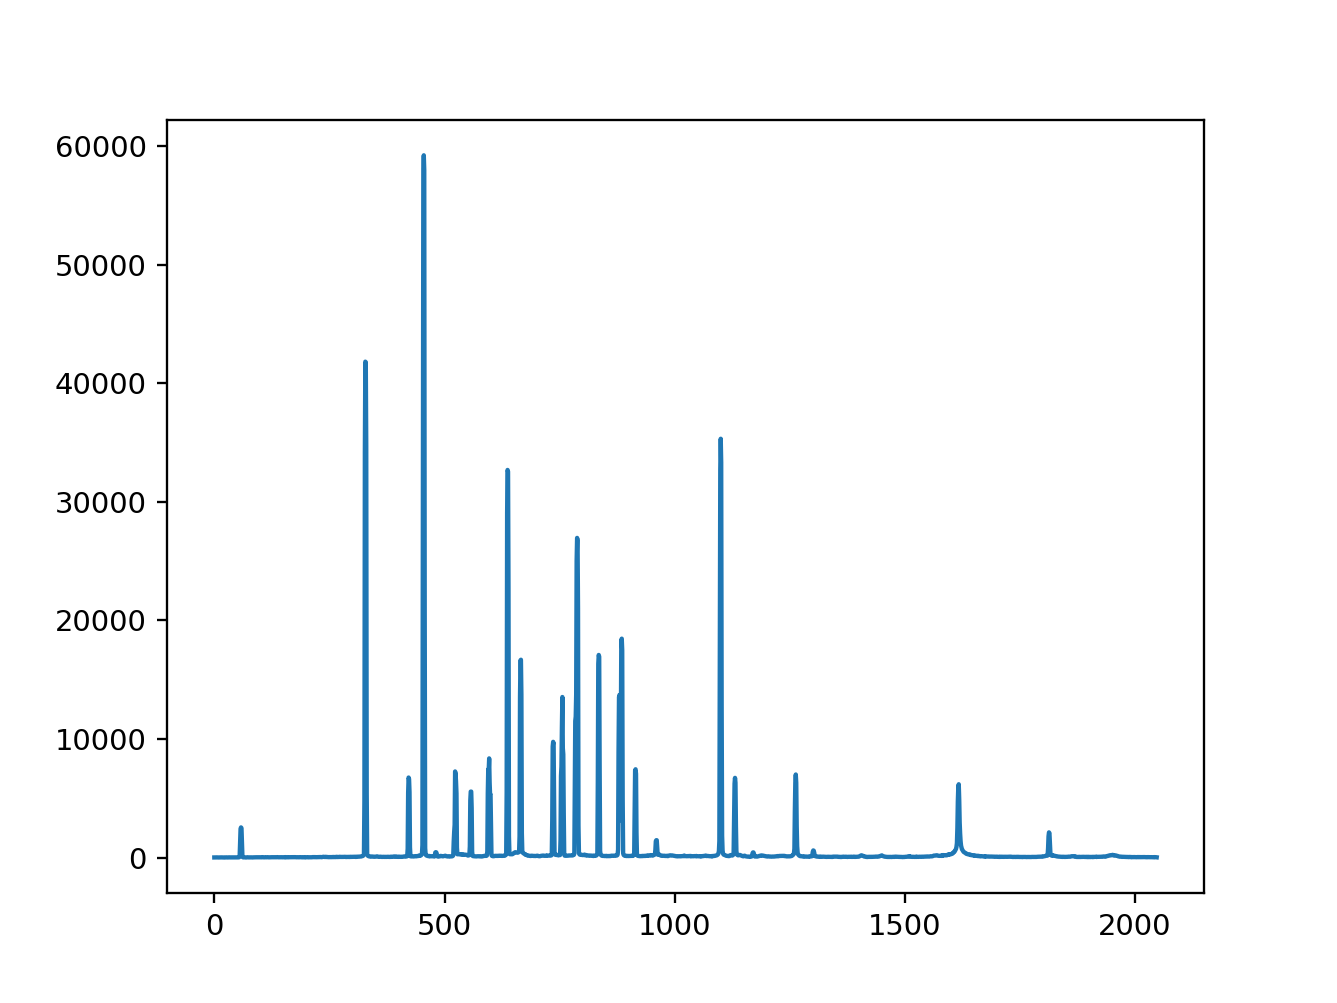

In [93]:
plt.clf()
ax = plt.gca()
ax.plot(spec)
plt.show()

### Find the lines

In [95]:
all_tcent, all_ecent, cut_tcent, icut, arc_cont_sub = wvutils.arc_lines_from_spec(spec)

In [96]:
all_tcent

array([  58.03849546,  328.51949702,  422.51124972,  454.89634082,
        481.3073873 ,  524.25656787,  557.39187332,  596.5302364 ,
        637.34294518,  665.50916617,  736.12325073,  755.78835053,
        788.04459311,  835.04964694,  880.05868202,  884.77181582,
        914.82236664,  960.10170505, 1099.94661843, 1130.96562698,
       1170.47670454, 1262.89180319, 1301.35647904, 1405.9410404 ,
       1449.14174243, 1616.6247718 , 1813.20860635])

In [97]:
wave.airtovac([9784.5, 10830.17]*units.AA)

<Quantity [ 9787.18326012, 10833.13678069] Angstrom>

In [98]:
pIDs = np.array([49.0, 548.4, 905.8, 1253.9, 1607.6])+9   # Approx
wvID = [5877.2490, 7386.0140,  8523.7830, 9660.4350,  10833.137]

In [99]:
iIDs = []
for pID in pIDs:
    idx = np.argmin(np.abs(pID-all_tcent))
    iIDs.append(idx)
iIDs = np.array(iIDs)
iIDs

array([ 0,  6, 16, 21, 25])

### Linelist

In [100]:
llist = waveio.load_line_lists(['ArI', 'HeI'])

### Fit

In [102]:
fit = fitting.iterative_fitting(spec, all_tcent, iIDs, wvID, llist, 11., plot_fil='vlt_fors2.png', n_first=3, verbose=True) 

[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 3: RMS = 0.0232011
[INFO]    :: fitting.py 180 iterative_fitting() - n_order = 4: RMS = 0.000582899
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 6679.13; 6679.95
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7069.17; 7067.24
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7274.94; 7282.54
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 7505.94; 7508.73
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8016.99; 8013.12
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8117.54; 8116.18
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 8410.52; 8411.64
[INFO]    :: fitting.py 218 iterative_fitting() - Rejecting arc line 9356.79; 9356.51


### Wavelengths

In [104]:
fit.keys()

dict_keys(['fitc', 'function', 'pixel_fit', 'wave_fit', 'weights', 'ions', 'fmin', 'fmax', 'xnorm', 'nspec', 'cen_wave', 'cen_disp', 'xrej', 'yrej', 'mask', 'spec', 'wave_soln', 'nrej', 'shift', 'tcent', 'rms'])

In [107]:
wave_soln = utils.func_val(fit['fitc'], np.arange(spec.size)/fit['xnorm'], fit['function'], minx=fit['fmin'], maxx=fit['fmax'])

In [108]:
wave_soln

array([ 5710.58704995,  5713.439658  ,  5716.29294615, ...,
       12260.48495547, 12263.80716869, 12267.12927589])

### Write

In [112]:
tbl = Table()
tbl['wave'] = wave_soln
tbl['flux'] = spec
tbl.meta['BINSPEC'] = 2
# Write
outpath=resource_filename('pypeit', 'data/arc_lines/reid_arxiv')
outroot='vlt_fors2_300I.fits'
outfile = os.path.join(outpath, outroot)
tbl.write(outfile, overwrite=True)
print("Wrote: {}".format(outfile))

Wrote: /home/xavier/local/Python/PypeIt/pypeit/data/arc_lines/reid_arxiv/vlt_fors2_300I.fits
